## Goal

The goal of this project is to find gene biomarker for weight loss response from a publicly available dataset. To this I trained a decision-tree method (XGBoost) using Bayesian optimization for tuning its hyperparameters. Finally I used theS HAP values to explain the results.

## Dataset

I downloaded the [Ornish](https://github.com/PanKonstantinos/MEvA-X/tree/main/Data/Ornish) dataset from the [MEvA-X tool](https://doi.org/10.1093/bioinformatics/btad384). This dataset is already normalized and contains microarry gene expression, with information of Age, Gender, COPD, Diabetes, and WeightLoss, making 13'520 features on 89 participants. WeightLoss is a binary variable: Responders for participants with a weight loss higher than 10% and Non_responders otherwise.


In [1]:
import pandas as pd

## diet dataset
ornish_url = 'https://raw.githubusercontent.com/PanKonstantinos/MEvA-X/refs/heads/main/Data/Ornish/diet_dataset.txt'

df = pd.read_csv(ornish_url, sep='\t', index_col=0).T

if (df.isna().any().any()):
  df.dropna(axis=0, inplace=True)

## response variables
labels_url = 'https://raw.githubusercontent.com/PanKonstantinos/MEvA-X/refs/heads/main/Data/Ornish/diet_labels.txt'

labels = pd.read_csv(labels_url, sep='\t', header=None, index_col=None).T
labels.columns = ['WeightLoss']
labels.set_index(df.index, inplace=True)

## concatenate
df = df.join(labels)

df


,A1CF,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,...,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,Age,Sex,COPD,Diabetes,WeightLoss
GSM1123226,1.997137,2.927813,3.379954,3.118075,4.511405,4.087969,2.214993,4.288835,3.572398,3.250973,...,2.020369,5.075711,6.088010,4.226737,5.179565,-0.648705,0.0,1.0,0.0,Non_responders
GSM1123229,1.977951,2.815217,3.554587,3.421110,3.975408,3.698030,2.135038,4.303349,3.600629,3.562200,...,2.151221,4.695243,5.209147,4.173184,4.658188,-0.988535,1.0,0.0,0.0,Responders
GSM1123232,2.000448,2.699376,3.859986,3.109845,4.412049,3.750196,1.999807,4.254621,3.444927,3.533278,...,2.090296,4.818034,6.367867,3.945843,4.634515,-0.412100,0.0,0.0,0.0,Responders
GSM1123235,2.163751,2.597491,3.735692,3.248038,4.336756,3.884665,2.133586,3.978215,3.238115,3.383351,...,2.000901,4.682398,6.498289,3.810110,4.363320,-0.714815,1.0,1.0,1.0,Responders
GSM1123238,2.264534,2.766004,3.839986,3.389460,4.405672,3.635781,2.041702,4.077370,3.724022,3.518026,...,2.227170,4.376936,5.653432,4.091409,3.860758,-0.064151,0.0,0.0,0.0,Responders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1616361,2.608056,2.817870,3.858801,3.601149,4.439976,4.121827,2.517568,4.439015,3.657229,3.683177,...,1.713461,4.850360,6.023210,4.395596,4.460750,-0.634787,1.0,1.0,0.0,Non_responders
GSM1616364,2.208693,3.098871,4.042131,3.798330,4.405658,4.081275,1.812455,4.774171,4.071347,3.866862,...,2.295336,4.973385,6.293176,4.548602,4.769321,0.175933,1.0,1.0,1.0,Non_responders
GSM1616370,1.971933,2.823615,3.955895,3.419127,4.502783,3.839190,2.568179,4.230036,3.708654,3.529116,...,1.678471,4.427966,5.851469,4.268339,4.546185,-0.417899,1.0,1.0,1.0,Responders
GSM1616373,1.921041,2.939931,3.601237,2.947529,4.007231,3.736109,1.795098,3.795344,3.311513,3.109000,...,1.836781,4.494768,5.271502,3.805281,4.191898,-0.434137,1.0,0.0,1.0,Non_responders


Then I encode WeightLoss to numeric [0,1] values

In [2]:
X = df.drop(columns=['WeightLoss'])

mapping = {'Non_responders': 0, 'Responders':1}
Y = df['WeightLoss'].map(mapping)

print(X.shape)
print(Y.value_counts())

(89, 13519)
WeightLoss
1    54
0    35
Name: count, dtype: int64


## Exploratory Data Analysis

Gene expression profile over participants

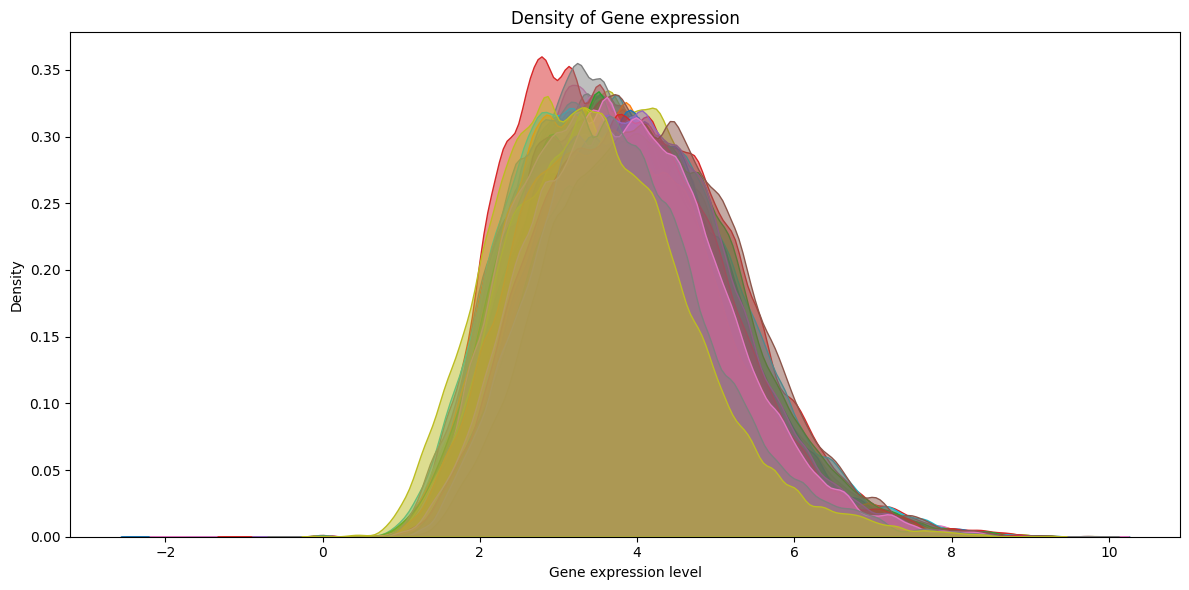

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# plot density for each sample
for i in range(X.shape[0]):
  sns.kdeplot(X.iloc[i,:], bw_adjust=0.5, fill=True, alpha=0.5)

plt.title('Density of Gene expression')
plt.xlabel('Gene expression level')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

PCA on gene expression data showing the distribution of participants colored by response status along the first two principal components.

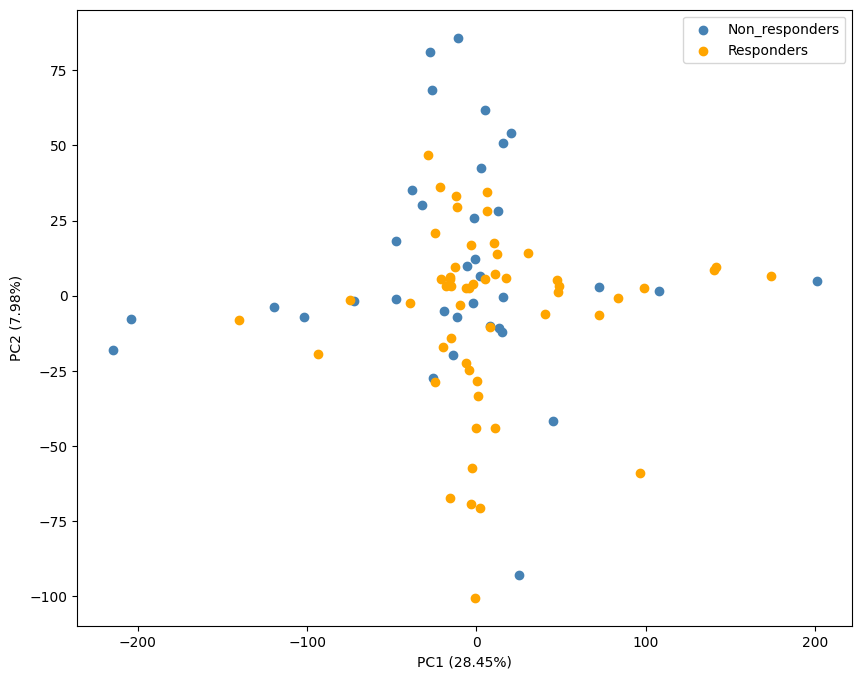

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# scatter plot of the first two principal components
plt.figure(figsize=(10, 8))

labels = Y
inv_mapping = {v: k for k, v in mapping.items()}
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], color='steelblue', label=inv_mapping[0])
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], color='orange', label=inv_mapping[1])
plt.legend()

plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))

plt.show()

## Quick and dirty approach

I built a 'vanilla' XGBoost model without exploring the hyperparameter space to see how a baseline model behaves. The workflow included:

- feature selection using mutual information (MI) to identify the top 300 genes most correlated with weight loss

- performance evaluation with AUROC and AUPRC

- model interpretation  with SHAP values

Note: I did not scale data because MI and tree-based methods (as XGBoost) are invariant to scale. Moreover, the dataset is already [normalized](https://github.com/PanKonstantinos/MEvA-X/tree/main/Data/Ornish).


### Splitting the dataset in training and test set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Feature selection by MI

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# get top genes
selector = SelectKBest(mutual_info_classif, k=300)
selector.fit(X_train, y_train)

# get top features
feature_index = selector.get_support(indices=True)
all_features = X_train.columns
selected_features = all_features[feature_index]

# build datasets with top features
X_train_filtered = pd.DataFrame(selector.transform(X_train),
                                columns=selected_features,
                                index=X_train.index)

X_test_filtered = pd.DataFrame(selector.transform(X_test),
                               columns=selected_features,
                               index=X_test.index)

### Training and evaluating XGBoost

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score
import xgboost as xgb 

# train XGBoost
xgb_model = xgb.XGBClassifier(
  n_estimators=100, 
  max_depth=3,
  eta=0.5,
  # early_stopping_rounds=10,
  eval_metric='aucpr' ## auc
)

# fit model
xgb_model.fit(
  X_train_filtered, y_train, 
  # eval_set=[(X_train_filtered, y_train),(X_test_filtered, y_test)],
  verbose=False
)

auroc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_filtered)[:, 1])
print(f"AUROC: {auroc:.4f}")

auprc = average_precision_score(y_test, xgb_model.predict_proba(X_test_filtered)[:, 1])
print(f"AUPRC: {auprc:.4f}")

AUROC: 0.5921
AUPRC: 0.8260


### XGBoost interpretability 

The plot below shows the contribute of the top biomarkers to weight loss.

Each dot represents a participant, while the color indicates gene expression level. Darker blue indicates lower expression, while darker red indicates higher expression.

Positive SHAP values indicate a higher probability of a participant of being a responder (weight loss), while negative SHAP values indicate a higher probability of being a non-responder (no weight loss).

Looking at the plot, we can conclude for example that participants with low levels of CDH13 and high levels of PIK3R2 and PSMC2 are associated with weight loss.


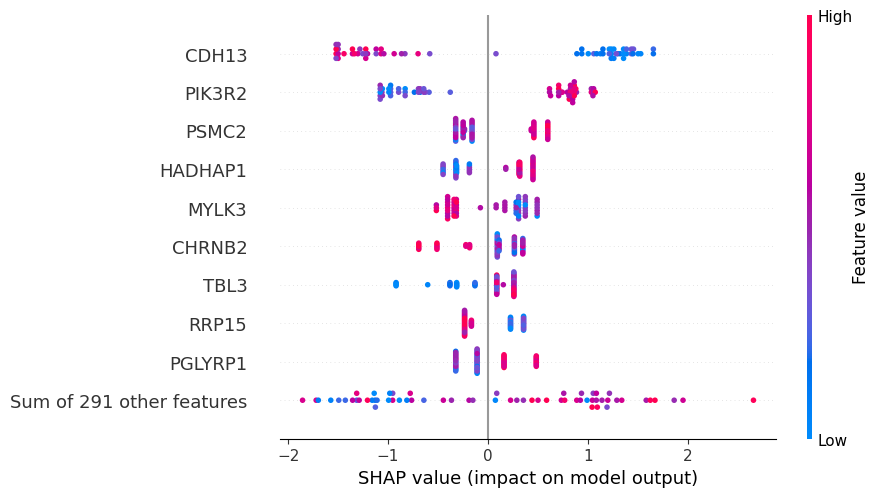

In [8]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_filtered)
shap.plots.beeswarm(shap_values)

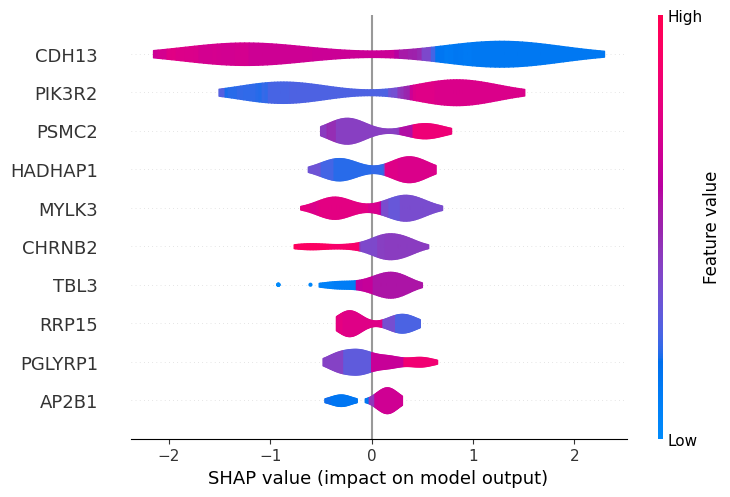

In [9]:
shap.plots.violin(shap_values, max_display=10)

Below we show the importance of the top biomarkers in predicting weight loss response.

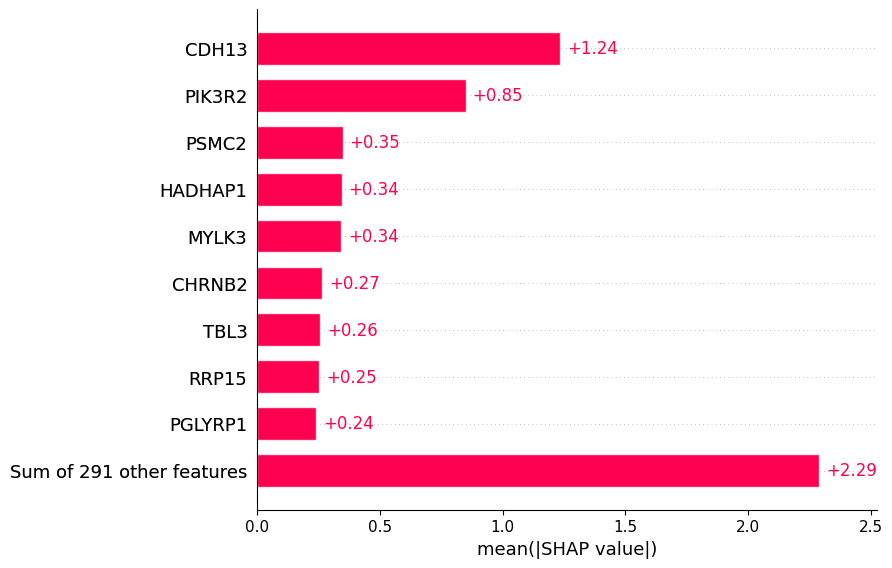

In [10]:
shap.plots.bar(shap_values)

## Tuning XGBoost hyperparameters

Starting from the 'vanilla' XGBoost model, I tuned the relevant hyperparameters using Bayesian optimization. To prevent data leakage, the supervised feature selection was performed within the cross-validation. Folds were stratified to balance participants labeled with the responder and non-responder class. As expected, the tuned XGBoost version outperformed the 'vanilla' baseline.

In [13]:
import warnings
## ignore: UserWarning: pkg_resources is deprecated as an API
warnings.filterwarnings('ignore', category=UserWarning, module='hyperopt.atpe') 

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
import multiprocessing
import xgboost as xgb
from hyperopt import hp, fmin, tpe, pyll, STATUS_OK, Trials, space_eval

def build_pipeline(params):
  pipeline = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=300)),
    ('classifier',
      xgb.XGBClassifier( 
        n_jobs=multiprocessing.cpu_count()-2,
        random_state=0,
        **params
      )
    )
  ])
  return pipeline

def hyperopt_pipeline(params):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        
  model = build_pipeline(params)
  
  losses = -cross_val_score(model, X_train, y_train,
                            scoring='average_precision', cv=skf) ## roc_auc

  return {
    'loss': np.mean(losses),
    'loss_variance': np.var(losses),
    'status': STATUS_OK
  }

In [14]:
hyperspace = {
  'eta': hp.loguniform('eta' , np.log(10**-2) , np.log(1)),
  'subsample': hp.uniform('subsample', 0.3, 1),
  'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1, 1000, 1)),
  'max_depth': pyll.scope.int(hp.quniform('max_depth', 3, 15, 1))
}

trials = Trials()

best = fmin(hyperopt_pipeline, hyperspace, 
            algo=tpe.suggest, 
            max_evals=10,
            trials=trials,
            # https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html
            rstate=np.random.default_rng(0))  ## important for reproducibility 

100%|██████████| 10/10 [12:49<00:00, 76.98s/trial, best loss: -0.8078696700125271]


### Fit the best model

In [15]:
best_params = space_eval(hyperspace, best)
best_model = build_pipeline(best_params)
best_model.fit(X_train, y_train)

auroc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"AUROC: {auroc:.4f}")

auprc = average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"AUPRC: {auprc:.4f}")

AUROC: 0.6118
AUPRC: 0.8358


### XGBoost interpretability

Most of the top biomarkers identified by the baseline and tuned models overlap (CDH13, HADHAP1, PIK3R2, RRP15, PSMC2, MYLK3), though their rankings differ (except for CDH13 which ranks first in both). However, the tuned model better clusters participants with high versus low gene expression, suggesting more robust predictions.

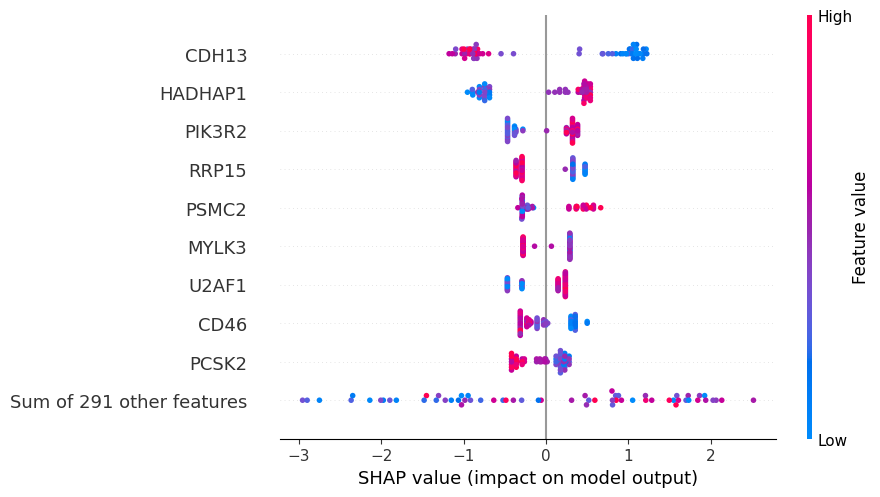

In [16]:
selector = best_model.named_steps['feature_selection']
classifier = best_model.named_steps['classifier']

top_feat_idx = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(selector.transform(X_train), 
                                columns=top_feat_idx,
                                index=X_train.index)

explainer = shap.Explainer(classifier)
shap_values = explainer(X_train_filtered)

shap.plots.beeswarm(shap_values)

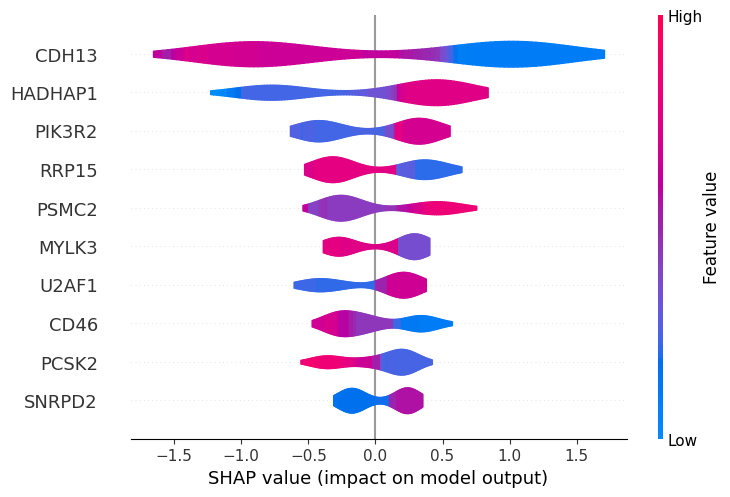

In [17]:
shap.plots.violin(shap_values, max_display=10)

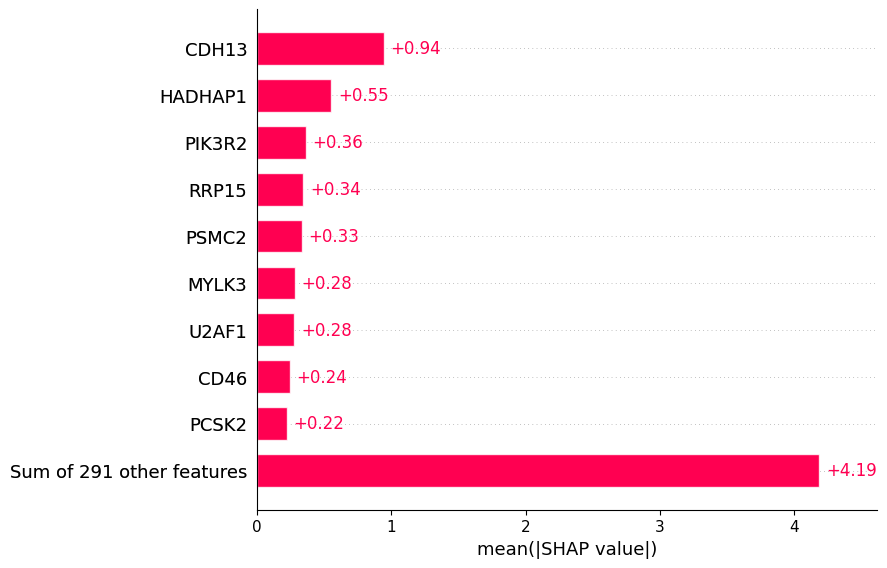

In [18]:
shap.plots.bar(shap_values)

## XGBoost versus Random Forest

I also compared two tree-based approaches XGBoost and Random Forest. In this dataset, XGBoost outperformed Random Forest as it showed lower loss over trials.

In [15]:
import sklearn.ensemble as rf

def build_model_pipeline(classifier='xgboost', params=hyperspace):
    
  if classifier == 'xgboost':
    model = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=300)),
    ('classifier',
      xgb.XGBClassifier( 
        n_jobs=multiprocessing.cpu_count()-2,
        random_state=0,
        **params
      )
    )
  ])
  else:
    model = Pipeline([
      ('feature_selection', SelectKBest(mutual_info_classif, k=300)),
      ('classifier',
        rf.RandomForestClassifier( 
          n_jobs=multiprocessing.cpu_count()-2,
          random_state=0,
          **params
        )
      )
    ])

  return model

def hyperopt_model_pipeline(params):
    
  skf = StratifiedKFold(n_splits=5, shuffle=True , random_state=0)
  
  classifier = params.pop('classifier_type')
  model = None

  if classifier == 'xgboost':
    model = build_model_pipeline(classifier='xgboost', params=params)
  else:
    model = build_model_pipeline(classifier='rf', params=params)
  
  losses = -cross_val_score(model, X_train, y_train,
                            scoring = 'average_precision', cv = skf) ## roc_auc
      
  return{
    'loss': np.mean(losses),
    'loss_variance' : np.var(losses),
    'status': STATUS_OK
  }


In [16]:
%%time

hyperspace = hp.choice('classifier_type',
  [{'classifier_type': 'xgboost',
    'n_estimators': pyll.scope.int(hp.quniform('xgb_n_estimators', 1 , 1000, 1)),
    'max_depth': pyll.scope.int(hp.quniform('xgb_max_depth', 1, 16, 1)),
    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(1)),
    'subsample': hp.uniform('subsample', 0.3, 1)
  },

  {'classifier_type': 'rf',
    'n_estimators': pyll.scope.int(hp.quniform('rf_n_estimators', 1 , 1000, 1)),
    'max_depth': pyll.scope.int(hp.quniform('rf_max_depth', 1, 16, 1)),
    'min_samples_split': pyll.scope.int(hp.quniform('min_samples_split', 2, 8, 1)),
    'min_samples_leaf': pyll.scope.int(hp.quniform('min_samples_leaf', 1, 32, 1))
  }
])

trials = Trials()

best = fmin(hyperopt_model_pipeline, 
            hyperspace, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials,
            rstate=np.random.default_rng(0))

100%|██████████| 10/10 [13:27<00:00, 80.76s/trial, best loss: -0.808512677798392]
CPU times: user 14min 4s, sys: 3.24 s, total: 14min 7s
Wall time: 13min 27s


Text(0, 0.5, 'loss')

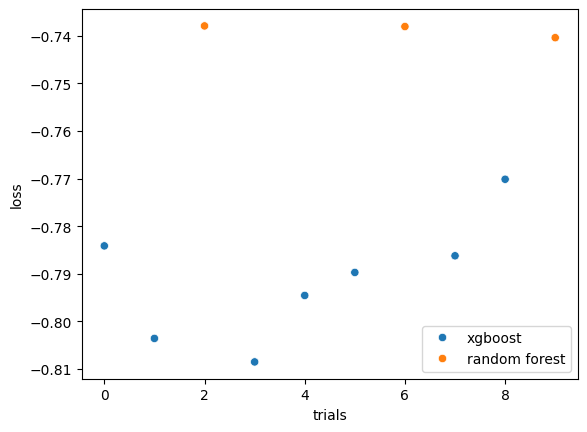

In [17]:
ax = sns.scatterplot(x =  range(len(trials.losses())) ,  
                     y =  trials.losses() , 
                     hue = np.array(['xgboost','random forest'])[trials.vals['classifier_type']] )
ax.set_xlabel('trials')
ax.set_ylabel('loss')